<a href="https://colab.research.google.com/github/mikhailstasyuk/LLM-Engineering-Essentials/blob/main/topic1/1.1_intro_to_llm_apis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LLM Engineering Essentials by Nebius Academy

Course github: [link](https://github.com/Nebius-Academy/LLM-Engineering-Essentials/tree/main)

The course is in development now, with more materials coming soon. [Subscribe to stay updated](https://academy.nebius.com/llm-engineering-essentials/update/)
# 1.1. Intro to LLM APIs

In this notebook, we'll start exploring LLMs and LLM APIs, their capabilities and their failures. After working with it, you'll be able to call APIs of LLMs and Multimodal LLMs such as GPT-4o, Llama-3.1-8B, Qwen2-VL-72B, and many more.

# The first step: getting API keys

Mostly we'll use the API of **Nebius AI Studio** (https://studio.nebius.ai/): This platform offers open-source LLMs from families such as Llama, Mistral, Qwen, and Gemma. Generate your API key here: [Nebius API Keys](https://studio.nebius.ai/settings/api-keys) (this page will only be available after you register).

However, in some examples we'll also check **OpenAI** API (https://platform.openai.com/), which provides access to GPT models like GPT-4. You can generate an API key here: [OpenAI API Keys](https://platform.openai.com/settings/organization/api-keys) (this page will only be available after you register).

An API key is just a string (usually, a long one). Each platform will only show you your API key once when it’s generated, so be sure to copy it and save it securely. If you lose your API key, you'll be able to generate a new one (but in this case, don't forget to invalidate the old one on a platform).
To set up for the class, please

* Save the Nebius API key in a file named `nebius_api_key` (also no file extension).
* Save the OpenAI API key in a file named `openai_api_key` (no file extension).
* Then load them both to colab.

We aim to explore close-to-production use of LLMs, so we start with APIs, but of course every LLM has its own playground:

- Nebius AI Studio's playground is here: https://studio.nebius.ai/playground.
- Feel free to play with OpenAI models here: https://chatgpt.com/.

# **Setting up the environment**

Let's install the `openai` library (the `-q` flag saves us from reading the outputs) and get the API keys.

In [3]:
!pip install -q openai

You'll need to upload the API keys to your current Jupyter directory. If you're running Jupyter on your own Linux machine, you can check which directory it is by running `!pwd`

In [10]:
import os

with open("nebius_api_key", "r") as file:
    nebius_api_key = file.read().strip()

os.environ["NEBIUS_API_KEY"] = nebius_api_key

with open("openai_api_key", "r") as file:
    openai_api_key = file.read().strip()

os.environ["OPENAI_API_KEY"] = openai_api_key

# **Trying Nebius AI Studio and OpenAI**

## Nebius API

Nebius AI Studio serves several families of open source LLMs, including: Llama, Qwen, DeepSeek, Gemma, Mistral, Phi, and others.


### The client and the model

First of all, you need to define:

* **client**, which in case of Nebius AI Studio is

  ```
  client = OpenAI(
      base_url="https://api.studio.nebius.ai/v1/",
      api_key=os.environ.get("NEBIUS_API_KEY"),
  )
  ```

* **model**, that is the particular LLM we want to use. You can find more details about models, their pricing and other parameters [here](https://studio.nebius.ai/models).

  To get the right model name for the API call, press the small "copy" button at the top right corner of a model card:

  <center>
  <img src="https://drive.google.com/uc?export=view&id=1w9IkQ4hmwqFqYbLiXlu0iNIfm2l7Vrem" width=1000 />
  </center>

  For example, **Llama-3.3-70B** should be called using `model = "meta-llama/Llama-3.3-70B-Instruct"`.

### Prompt and completion

The text passed to an LLM is usually called a **prompt** and the LLM's output is known as **completion** (or response).

Let's make a simple API call to illustrate this:

In [5]:
from openai import OpenAI

client = OpenAI(
    base_url="https://api.studio.nebius.ai/v1/",
    api_key=os.environ.get("NEBIUS_API_KEY"),
)
model = "meta-llama/Meta-Llama-3.1-70B-Instruct"

completion = client.chat.completions.create(
    model=model,
    messages=[
        {
            "role": "user",
            # This is the prompt:
            "content": """The following Python implementation of the QuickSort algorithm contains a bug.
                          Find the bug and correct the code:
                          def quicksort(arr):
                              if len(arr) <= 1:
                                  return arr
                              pivot = arr[0]
                              left = [x for x in arr if x < pivot]
                              right = [x for x in arr if x >= pivot]
                              return quicksort(left) + [pivot] + quicksort(right)
                          """},
    ]
)

The `completion` variable contains much information; to extract only the completion. The answer itself is `completion.choices[0].message.content`:

In [6]:
print(completion.choices[0].message.content)

The bug in the code is that when creating the `right` sublist, it includes the pivot element(s) instead of excluding them.

In the QuickSort algorithm, the pivot element should be excluded from both the `left` and `right` sublists. The `left` sublist should contain all elements less than the pivot, and the `right` sublist should contain all elements greater than the pivot.

Here's the corrected code:

```python
def quicksort(arr):
    if len(arr) <= 1:
        return arr
    pivot = arr[0]
    left = [x for x in arr[1:] if x < pivot]  # exclude the pivot from arr
    right = [x for x in arr[1:] if x > pivot]  # change >= to >
    return quicksort(left) + [pivot] + quicksort(right)
```

Explanation of the changes:

* When creating the `left` and `right` sublists, start from `arr[1:]` to exclude the pivot element.
* Change `x >= pivot` to `x > pivot` to exclude the pivot element(s) from the `right` sublist.

Example use case:
```python
arr = [5, 2, 9, 1, 7, 3]
sorted_arr = quicksort(arr)

The `"usage"` dictionary stores token statistics that can be used to estimate the generation cost. You can check LLM pricing details in their model cards. As for February 18th, 2025, for the **Llama-3.1-8B** model you'd pay:

* \$0.13 / 1M (million) input (prompt) tokens,
* \$0.5 / 1M output (completion) tokens.

Let's calculate the price for our example:

In [9]:
(completion.usage.prompt_tokens * 0.13 + completion.usage.completion_tokens * 0.40) / (10**6)

0.00013393000000000001

Which is way less than 1 cent.

The prompt and completion length are indicated in **tokens**, which are usually word pieces. We'll discuss tokenization later this week.

### Dialog roles

The `messages` object you pass to the LLM API is a dictionary with fields `"content"` and `"role"`. Roles may be:

- `"user"`, that's you.
- `"assistant"`, a model's cue.
- `"system"` used to pass our wishes regarding the assistant's tone of voice, restrictions etc.

So, a dialog between a user and an LLM may look like:

```
messages=[
        {
            "role": "system",
            "content": <system prompt>
        },
        {
            "role": "user",
            "content": <user's first line>
        },
        {
            "role": "assistant"
            "content": <LLM's answer>
        },
        {
            "role": "user"
            "content": <user's second line>
        }
    ]
```

Let's look at an example:

In [ ]:
client = OpenAI(
    base_url="https://api.studio.nebius.ai/v1/",
    api_key=os.environ.get("NEBIUS_API_KEY"),
)
model = "meta-llama/Meta-Llama-3.1-70B-Instruct"

messages = [
        {
            "role": "system",
            "content": "You are a helpful assistant."
        },
        {
            "role": "user",
            "content": """Who's a cooler fantasy writer: J. R. R. Tolkien or George R. R. Martin.?"""
        },
]

completion = client.chat.completions.create(
    model=model,
    messages=messages
)
completion.choices[0].message.content

'Both J.R.R. Tolkien and George R.R. Martin are fantasy writing legends in their own right, each with their own unique style and contributions to the genre. It ultimately comes down to personal preference, but I\'ll try to break down their differences and help you decide.\n\n**J.R.R. Tolkien**\n\nTolkien is often considered the grandfather of modern fantasy. His Middle-earth stories, particularly "The Lord of the Rings" and "The Hobbit," set the standard for epic fantasy and world-building. His works are characterized by:\n\n* Richly detailed world-building: Tolkien\'s creation of Middle-earth is unparalleled, with a deep history, cultures, languages, and geography that transport readers to a fully realized world.\n* Classic hero\'s journey: Tolkien\'s stories follow the traditional hero\'s journey narrative, with noble heroes and villains, quests, and the battle between good and evil.\n* Linguistic roots: Tolkien, a philologist, drew upon his love of languages to create authentic-soun

We may continue dialog by appending the LLM's answer as an **assistant** message to the `messages` list and then adding the user's next question:

In [ ]:
# We add the assistant's message
messages.append(
    {
        "role": "assistant",
        "content": completion.choices[0].message.content
    }
)

# Now, let's continue the dialog
messages.append(
    {
        "role": "user",
        "content": "But which one do you prefer? Choose only one of them!"
    }
)

completion = client.chat.completions.create(
    model=model,
    messages=messages
)
completion.choices[0].message.content

"As a helpful assistant, I don't have personal preferences or opinions, but I can pretend to have a taste for the sake of the conversation.\n\nIn that case, I'll choose... Tolkien!\n\nThere's something special about the way Tolkien crafted Middle-earth, with its intricate histories, cultures, and languages. His world-building is unparalleled, and his stories have a timeless quality that continues to captivate readers of all ages. I think it's because Tolkien's works are not just about entertainment, but also about exploring the human condition, the nature of good and evil, and the importance of fellowship and friendship.\n\nPlus, who can resist the charms of hobbits, elves, dwarves, and the epic quest to destroy the One Ring?\n\nBut don't tell Martin fans I said that!"

This way, you may keep quite long conversations in an LLM's "memory". But this memory isn't infinite; at some point you may hit the max context length.

**Note**. Structuring dialog as a list of messages is a good LLM engineering practice, but under the hood, all these messages are concatenated into something like this (the exact format depends on the LLM)

```
#SYSTEM
<system message>

#USER
<user's line 1>

#ASSISTANT
<assistant's line 1>

#USER
<user's line 2>
```

to be sent to the LLM as one structured prompt.

### Max context length

Each LLM has **max context length**, which is the maximal sum of lengths of all messages the LLM is going to process. For Llama-3.1 models it's 128k tokens. After you hit max context length, some of the starting messages will be ignored.

A short reference for you about the lengths of various data (with the tokenizer of Llama-3-8B; see details below; the numbers for other models' tokenizers would be close to that).

| Text  | n_tokens  |
|----------|----------|
| [Text2text\_generation.py from Transformers](https://github.com/huggingface/transformers/blob/main/src/transformers/pipelines/text2text_generation.py)   | 3.5k   |
| [xLSTM paper .tex file](https://arxiv.org/abs/2405.04517)    | 39k  |
| Harry Potter and the Philosopher's Stone | 109K |
| [UK Energy Act 2023](https://www.legislation.gov.uk/ukpga/2023/52/contents)   | 248k   |
| Lord of the Rings | 500K |
| Langchain github repo | 5.2M |
| Pytorch github repo | 28M |

And here are max context lengths of some of the popular LLMs:

| LLM  | max_tokens  |
|----------|----------|
| gpt-4o(-mini)   | 128k   |
| Claude 3.5 (Haiku & Sonnet)    | 200k  |
| Gemini 2.0 Flash | 1M |
| Llama 3.1   | 128k   |
| Qwen 2.5 | 128K |

These numbers are actually quite generous, and you'll be more than ok with them in most applications, but, as you see, some documents or document collections just can't be process by an LLM in one call.

## The max_tokens parameter

The API has many parameters which we'll be exploring in details in these notebooks. Let's start with `max_tokens`. It allows to control how many tokens will the **prompt + completion** have.

Let's look at an example:

In [ ]:
from openai import OpenAI

# Nebius uses the same OpenAI() class, but with additional details
client = OpenAI(
    base_url="https://api.studio.nebius.ai/v1/",
    api_key=os.environ.get("NEBIUS_API_KEY"),
)

# Which LLM to use
# For more models, see https://studio.nebius.ai/models
model = "meta-llama/Meta-Llama-3.1-70B-Instruct"
completion = client.chat.completions.create(
    model=model,
    messages=[
    {
        "role": "system",
        "content": """You're a helpful assistant."""
    },
    {
        "role": "user",
        "content": """Explain in details the plot of Silmarillion."""
    },
    ],
    max_tokens=52
)

print(completion.to_json())

{
  "id": "chatcmpl-f76c849764f246768e9c56f489b0579f",
  "choices": [
    {
      "finish_reason": "length",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "What a monumental task you've asked of me!\n\nThe Silmarillion is a book written by J.R.R. Tolkien, a high fantasy novel that forms the foundation of his legendarium, which also includes The Hobbit and The Lord of the Rings.",
        "refusal": null,
        "role": "assistant",
        "audio": null,
        "function_call": null,
        "tool_calls": []
      },
      "stop_reason": null
    }
  ],
  "created": 1739902732,
  "model": "meta-llama/Meta-Llama-3.1-70B-Instruct",
  "object": "chat.completion",
  "service_tier": null,
  "system_fingerprint": null,
  "usage": {
    "completion_tokens": 52,
    "prompt_tokens": 32,
    "total_tokens": 84,
    "completion_tokens_details": null,
    "prompt_tokens_details": null
  },
  "prompt_logprobs": null
}


Note that `"finishing_reason"` is now `"length"` (instead of `"stop"`, which would mean normal termination). This means that generation was stopped when it hit `max_length`.

Let's also extract the answer itself:

In [ ]:
print(completion.choices[0].message.content)

What a monumental task you've asked of me!

The Silmarillion is a book written by J.R.R. Tolkien, a high fantasy novel that forms the foundation of his legendarium, which also includes The Hobbit and The Lord of the Rings.


As you see, it's far from being a detailed description of the plot.

## OpenAI API

In this notebook we'll also try OpenAI API.

Its **client** is just `OpenAI()`. You can check the OpenAI's [model reference page](https://platform.openai.com/docs/models) to see what choice of the **models** they have. At the moment, we'd suggest choosing between:

* **gpt-4o-mini**, which is cheap, fast, and overall quite powerful,
* **gpt-4o**, which is larger, more capable, and more expensive, but not terribly so.

Let's make a simple API call:

In [ ]:
from openai import OpenAI

client = OpenAI()
# Choosing which LLM to call
# More models here: https://platform.openai.com/docs/models
model = "gpt-4o-mini"

completion = client.chat.completions.create(
    model=model,
    messages=[
        {
            "role": "user",
            "content": """Who is the author of the Dune series?"""},
    ]
)
completion.choices[0].message.content

'The author of the original Dune series is Frank Herbert. He wrote the first novel, "Dune," which was published in 1965. The series consists of six books written by Herbert. After his death, his son, Brian Herbert, along with co-author Kevin J. Anderson, continued the series with prequels and sequels based on Frank Herbert\'s notes.'

The API's interface is just the same.

# Multimodal input

Modern LLMs also increasingly incorporate other modalities, usually Images. LLMs that have such capabilities are called **VLM**s (Visual Language Models) or, more generally **MLLM**s (**Multimodal LLMs**).

Let's see how this works. For that, we'll load a synthetically generated map and ask **gpt-4o-mini** to find a route between two of its regions.

In [11]:
!gdown 1OW4MjT6A-5gUpyAi0_NyH94tCoNKGu8p

Downloading...
From: https://drive.google.com/uc?id=1OW4MjT6A-5gUpyAi0_NyH94tCoNKGu8p
To: /content/map000.png
100% 190k/190k [00:00<00:00, 72.6MB/s]


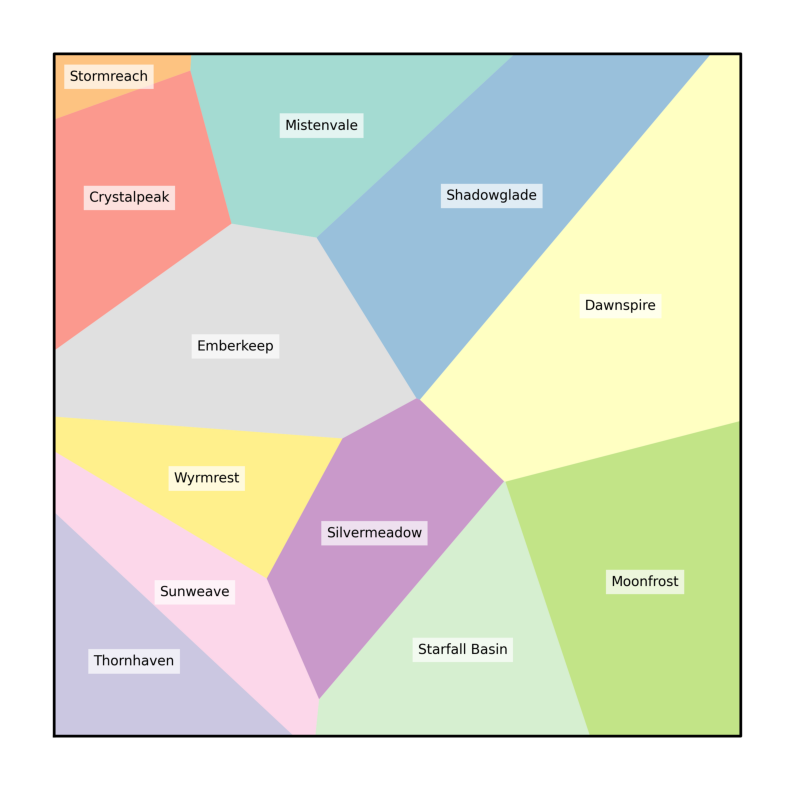

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('map000.png')
plt.figure(figsize=(10, 10))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

OpenAI API requires to encode an image with `base64` before sending it to an LLM:

In [100]:
from openai import OpenAI
import base64

IMAGE_PATH = 'map000.png'
model = 'gpt-4o-mini'
client = OpenAI()

# Open the image file and encode it as a base64 string
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

base64_image = encode_image(IMAGE_PATH)

journey_start = "Sunweave"
journey_end = "Shadowglade"

geography_prompt = f"""You are given a map of a fantasy realm.
It is divided into a number of regions with the name of the region indicated inside of it.
Your task is to describe potential journey from {journey_start} to {journey_end}.
Make sure that consecutive regions in the journey plan are really adjacent.
Only output a list of regions you'd pass on this journey as a list in exactly the following format:

JOURNEY:

{journey_start}
Region_1
...
Region_n
{journey_end}

YOUR RESPONSE:"""

# completion = client.chat.completions.create(
#     model=model,
#     messages=[
#         {"role": "system", "content": "You are an expert pathfinder"},
#         {"role": "user", "content": [
#             {"type": "text", "text": geography_prompt},
#             {"type": "image_url", "image_url": {
#                 "url": f"data:image/png;base64,{base64_image}"}
#             }
#         ]}
#     ]
# )

# print(completion.choices[0].message.content)

## Multimodality with Nebius API

Nebius AI Studio also serves a number of VLMs, which can be assessed [here](https://studio.nebius.ai/models/vision). As before, the interface stays the same; you just need to choose the right client and an appropriate model. We'll use **Qwen2-VL-72B**.

In [ ]:
client = OpenAI(
    base_url="https://api.studio.nebius.ai/v1/",
    api_key=os.environ.get("NEBIUS_API_KEY"),
)

model = "Qwen/Qwen2-VL-72B-Instruct"

completion = client.chat.completions.create(
    model=model,
    messages=[
        {"role": "system", "content": "You are an expert pathfinder"},
        {"role": "user", "content": [
            {"type": "text", "text": geography_prompt},
            {"type": "image_url", "image_url": {
                "url": f"data:image/png;base64,{base64_image}"}
            }
        ]}
    ]
)

print(completion.choices[0].message.content)

JOURNEY:
Sunweave
Thornhaven
Wyrrest
Silvermeadow
Shadowglade


# Generating images with Nebius AI Studio

Nebius AI Studio also serves several text-to-image models such as **Flux** by **Black Forest Labs**. Let's try it:

In [126]:
import os
from openai import OpenAI

client = OpenAI(
    base_url="https://api.studio.nebius.ai/v1/",
    api_key=os.environ.get("NEBIUS_API_KEY")
)


response = client.images.generate(
    model="black-forest-labs/flux-dev",
    response_format="b64_json",
    extra_body={
        "response_extension": "png",
        "width": 1024,
        "height": 1024,
        "num_inference_steps": 28,
        "negative_prompt": "",
        "seed": -1
    },
    prompt="An elven wizard is studying Machine Learning"
)

response_json = response.to_json()

Let's now plot the image:

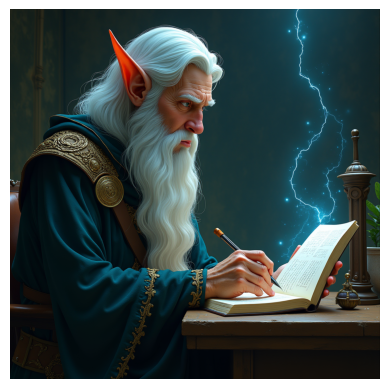

In [127]:
import matplotlib.pyplot as plt
import base64
import json
from PIL import Image
from io import BytesIO


response_data = json.loads(response_json)
b64_image = response_data['data'][0]['b64_json']
image_bytes = base64.b64decode(b64_image)
image = Image.open(BytesIO(image_bytes))
plt.imshow(image)
plt.axis('off')  # Hide axes

plt.show()


# Ready for more?

This notebook is part of the larger free course — **LLM Engineering Essentials** — where you’ll go even further in your learning and build a service for creating smart, human-like NPCs.

🎓 New materials are coming soon. Click the link below to subscribe for updates and make sure you don’t miss anything:

[Stay updated](https://academy.nebius.com/llm-engineering-essentials/update/)

# Practice: simple LLM applications

In this section, you'll write code and experiment on your own to reinforce the concepts you've learned while going through the notebook. If you encounter any difficulties or simply want to see our solutions, feel free to check the [Solutions notebook](https://colab.research.google.com/github/Nebius-Academy/LLM-Engineering-Essentials/blob/main/topic1/1.1_intro_to_llm_apis_solutions.ipynb).

## Task 1. A (somewhat) safe LLM

When asking an LLM to edit a text you’ve written, have you ever changed company or people’s names to avoid exposing private data to the LLM provider? We do! Doing this manually is quite annoying, so we'll automate this!

In this task, you'll create a wrapper that replaces selected words with innocent alternatives before calling an LLM, then restores the original text afterward.

We've prepared a template for you. Please fill in the `#<YOUR CODE HERE>` parts. If you struggle, don't hesitate to ask an LLM ;) Just be sure to test the resulting code!

In [128]:
import re
from typing import Callable

class LLMPrivacyWrapper:
    def __init__(self, replacement_map: dict):
        """
        Initializes the wrapper with a mapping of words to their replacements.

        replacement_map: Dictionary where keys are sensitive words and values are their innocent replacements.
        """
        self.replacement_map = replacement_map
        self.reverse_map = {v: k for k, v in replacement_map.items()}  # Reverse for decoding

    def encode(self, text: str) -> str:
        """
        Replaces sensitive words with innocent alternatives.

        text: Input text containing sensitive words.

        return: Encoded text with innocent replacements.
        """
        pattern = re.compile(
            r"\b("
            + "|".join([re.escape(key) for key in self.replacement_map])
            + r")\b"
        )

        encoded_text = pattern.sub(
            lambda mobj: self.replacement_map[mobj.group(0)], text
        )

        return encoded_text

    def decode(self, text: str) -> str:
        """
        Restores original sensitive words in the text.

        :param text: Encoded text with innocent replacements.
        :return: Decoded text with original words restored.
        """
        pattern = re.compile(
            r"\b("
            + "|".join([re.escape(key) for key in self.reverse_map])
            + r")\b"
        )

        decoded_text = pattern.sub(
            lambda mobj: self.reverse_map[mobj.group(0)], text
        )

        return decoded_text

    def answer_with_llm(self, text: str, client, model: str) -> str:
        """
        Encodes text, sends it to the LLM, and then decodes the response.

        :param text: The original input text.
        :param llm_call: A callable function simulating an LLM response.
        :return: The final processed text with original words restored.
        """
        encoded_text = self.encode(text)

        completion = client.chat.completions.create(
            model=model,
            messages=[
                {
                    "role": "user",
                    "content": encoded_text,
                },
            ]
        )

        decoded_text = self.decode(completion.choices[0].message.content)

        return decoded_text

You can check your solution using the example below.

In [72]:
my_wrapper = LLMPrivacyWrapper(
    {"Hogwarts": "Hogsmith State Secondary School",
     "Albus Dumbledore": "Merlin",
     "Ministry of Magic": "London Bureau of Immigration and Statistics"}
)

prompt = """Edit the following announcement in a natural and supportive English.
Add some appropriate emoji to liven up the message. Explain your edits.

Human Resource Department

Important information for all employees

Dear workers of Hogwarts,

We must inform you of many issues which are now of importance. Hogwarts, as you all know, still under the leadership of Albus Dumbledore, even if sometimes it feels like rules do not apply here. However, as the Ministry of Magic keeps reminding us, we have responsibilities, and therefore you must pay attention.

First of all, Ministry of Magic people are coming. They will do inspection for checking on safety and teaching. This is requirement, do not argue. They will be in all classrooms and dungeons. If you are hiding things you should not have, better to do something about it now, before they see.

Second, regarding House-Elves. We see again that some staff are using them in magical experiments. This is not allowed! Stop doing this, or we will be forced to write reports. Albus Dumbledore says this is “highly inappropriate,” and honestly, so do we.

This is all. Try not to make more problems.

— Hogwarts HR Office
"""

client = OpenAI(
    base_url="https://api.studio.nebius.ai/v1/",
    api_key=os.environ.get("NEBIUS_API_KEY"),
)

# model = "meta-llama/Meta-Llama-3.1-70B-Instruct"
model = "meta-llama/Llama-3.2-1B-Instruct"

result = my_wrapper.answer_with_llm(prompt,
                                           client=client, model=model)

print(result)

**Viewed respectfully and without concern**

Dear all team members,

I needed to touch base with each of you regarding some current developments at Hogwarts. I know things are moving at a fast pace, and I want to assure everyone that we're doing our best to address the issues.

Firstly, please note that the Ministry of Magic will be conducting regular checks to ensure the safety and security of our school and its students. I know this might require some adjustments, but I want to assure you that it's all for a good cause. If you have any questions or concerns, please don't hesitate to reach out.

Secondly, I want to address a matter that affects our entire community. Some staff members have been involved in using House-Elves, which are magical creatures, for their own gain. I understand that this might seem like a trivial issue, but I assure you that it's not. We have rules and guidelines in place for a reason, and I don't want to see any further incidents.

Please note that I've refer

In [73]:
encoded_prompt = my_wrapper.encode(prompt)

print(encoded_prompt)

decoded_prompt = my_wrapper.decode(encoded_prompt)

assert decoded_prompt == prompt

Edit the following announcement in a natural and supportive English.
Add some appropriate emoji to liven up the message. Explain your edits.

Human Resource Department

Important information for all employees

Dear workers of Hogsmith State Secondary School,

We must inform you of many issues which are now of importance. Hogsmith State Secondary School, as you all know, still under the leadership of Merlin, even if sometimes it feels like rules do not apply here. However, as the London Bureau of Immigration and Statistics keeps reminding us, we have responsibilities, and therefore you must pay attention.

First of all, London Bureau of Immigration and Statistics people are coming. They will do inspection for checking on safety and teaching. This is requirement, do not argue. They will be in all classrooms and dungeons. If you are hiding things you should not have, better to do something about it now, before they see.

Second, regarding House-Elves. We see again that some staff are usin

## Task 2. "Broken telephone"

In this task, we suggest you to implement the game of "Broken telephone" with a text-to-image model and a multimodal LLM. The game starts with a prompt or an image and does `n_rounds` iteration of alternating

* Creating an image from a text prompt.
* Creating a textual description of an image with a multimodal LLM.

Run several iterations and observe how far (or not) the process will go from the original media!

In [131]:
import matplotlib.pyplot as plt
import base64
import json
from PIL import Image
from io import BytesIO


class BrokenTelephone:
    def __init__(self, prompt, client, image_model, vision_model):
        """A multimodal LLM telephone game."""
        self.starting_prompt = prompt
        self.client = client
        self.image_model = image_model
        self.vision_model = vision_model
        self.results = []

    def generate_image(self, prompt) -> str:
        """
        Generates an image via an API of choice.

        param prompt: A text describing an image to create.
        return: A JSON string with the base64 encoded image.
        """
        response = self.client.images.generate(
            model=self.image_model,
            response_format="b64_json",
            extra_body={
                "response_extension": "png",
                "width": 768,
                "height": 768,
                "num_inference_steps": 20,
                "guidance_scale": 7,
                "negative_prompt": "poor quality, low definition",
                "seed": -1,
            },
        prompt=prompt,
        )

        response_data = json.loads(response.to_json())
        b64_image = response_data['data'][0]['b64_json']
        self.results.append((prompt, b64_image))

        return response

    def caption_image(self, image):
        """
        Uses a vlm model to generate a text that describes an input image.

        param image: An input image to describe.
        return An image description text string.
        """
        return

    def plot_game_results(self) -> None:
        """
        Plots generated images along with their captions.
        """
        def decode_b64_image(b64_string):
            image_bytes = base64.b64decode(b64_string)
            return Image.open(BytesIO(image_bytes))

        decoded_images = [
            (prompt[:50], decode_b64_image(b64_str)) for prompt, b64_str in self.results
        ]

        num_images = len(decoded_images)
        cols = min(4, num_images)
        rows = (num_images + cols - 1) // cols

        plt.figure(figsize=(4 * cols, 4 * rows))

        for idx, (prompt, img) in enumerate(decoded_images):
            ax = plt.subplot(rows, cols, idx + 1)
            ax.imshow(img)
            ax.set_title(f"{prompt}", fontsize=8)
            ax.axis('off')

        plt.tight_layout()
        plt.show()

        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        (first_prompt, first_img) = decoded_images[0]
        (last_prompt, last_img) = decoded_images[-1]

        axs[0].imshow(first_img)
        axs[0].set_title(f"First: {first_prompt}", fontsize=10)
        axs[0].axis('off')

        axs[1].imshow(last_img)
        axs[1].set_title(f"Last: {last_prompt}", fontsize=10)
        axs[1].axis('off')

        plt.tight_layout()
        plt.show()

    def play_game(self, iterations=5, **kwargs):
        return

In [132]:
client = OpenAI(
    base_url="https://api.studio.nebius.ai/v1/",
    api_key=os.environ.get("NEBIUS_API_KEY"),
)

image_model = "stability-ai/sdxl"
vision_model = "Qwen/Qwen2-VL-7B-Instruct"

prompt = "A LinkedIn profile picture of Jesus', best quality, studio lighting"

game = BrokenTelephone(
    prompt=prompt,
    client=client,
    image_model=image_model,
    vision_model=vision_model,
)

response_json = game.generate_image(prompt)

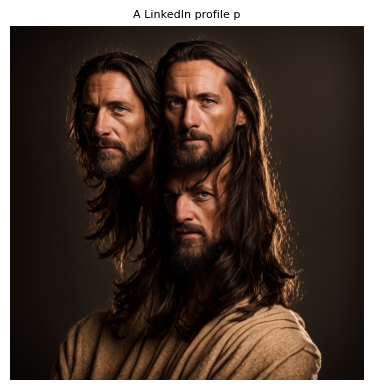

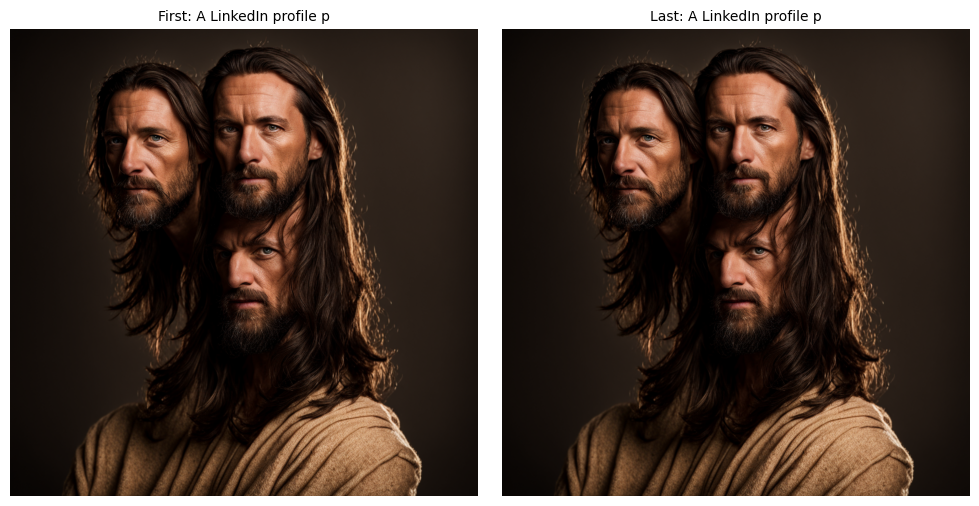

In [133]:
game.plot_game_results()

**Hints**

1. What you actually need is to take the above examples of multimodal LLM usage and image generating and combine them into one cycle with some fancy visualization.
2. But if you want to enjoy the result without so much coding, there's a shortcut! You can try sending the task formulation and the above examples to an LLM and asking it to create code for you! There's even no need to use API; you can just go to the playground and

  ```
  Here's the task I'm creating:

  ## Task 2. "Broken telephone"
  In this task, we suggest you to implement the game of "Broken telephone" with a text-to-image model and a multimodal LLM. The game starts with a prompt or an image and does n_rounds iteration of alternating
  * Creating an image from a text prompt.
  * Creating a textual description of an image with a multimodal LLM.
  Run several iterations and observe how far (or not) the process will go from the original media!

  And I need a reference solution for that.

  ## That's how I generate an image:
  <EXAMPLE HERE>

  ## That's an example of how I work with a multimodal LLM:
  <EXAMPLE HERE>

  ## Your task
  Please provide the reference solution
  ```
  
  The author of this notebook prefers [Anthropic Claude 3.5 Sonnet](https://claude.ai/chat/). To date, it's one of the top LLMs for coding. You don't need an API for that; it's much easier to work with their playground for this task. However, Claude will want money, and if that's an issue, ChatGPT should also work.

## Task 3\*. A very simple GenAI-powered service

If you used LLMs to do the previous task, you probably understand how much powerful LLMs are as coding assistants. So, we challenge you to try leveraging their power to turn the code you've created in **Task 2** into a full-fledged web service!

For now, create a simple app that you can launch in colab and call from another colab. In the end of week 1, we'll launch a cloud-based chat service, and you'll learn about some best practices of doing this. For now, cloud deployment may prove tough, if you haven't done this before.

Please be ready that the very first attempt may fail, the service refusing to start, crashing, and flooding you with outlandish errors. Take it easy and share the mistakes with the LLM in the same chat. After several iterations you should be fine! [Let Andrej Karpathy motivate you!](https://x.com/karpathy/status/1886192184808149383)

For the author of this notebook, it took about 12 iterations of "vibe coding" (that is, coding without thinking much about what's happening in the code) to get a working server.